In [1]:
from scipy.io import netcdf
import scipy
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
import AMM60_tools
%matplotlib inline

## Extract the thermocline depth (depth of the 13C isotherm) for St1 Celtic sea mooring ##

In [22]:
mooring_num = 'ST1'
max_depth = 150
len_seg = 256

In [23]:
def find_segment(filename):
    # Get the min/max index of available data.
    delta_obs = AMM60_tools.readMODELnc(filename,'delta_nt_obs')
    delta_obs = np.ma.masked_where(delta_obs == 0, delta_obs)
    delta_obs = np.ma.masked_invalid(delta_obs)
    Index_start = np.argwhere(delta_obs)[0]
    Index_end = np.argwhere(delta_obs)[-1]
    
    return[Index_start,Index_end]

def compute_fft(filename,Index_start,Index_end):
    ### Load the data ###
    delta_obs = AMM60_tools.readMODELnc(filename,'delta_obs')[Index_start:Index_end]
    delta_mod = AMM60_tools.readMODELnc(filename,'delta_mod')[Index_start:Index_end]
    delta_3d_obs = AMM60_tools.readMODELnc(filename,'delta_nt_obs')[Index_start:Index_end]
    delta_3d_mod = AMM60_tools.readMODELnc(filename,'delta_nt_mod')[Index_start:Index_end]

    ### FFT ###
    print(len(delta_mod))
    fftobs = np.zeros((int(len_seg/2)+1,len(delta_mod)))
    fftmod = np.zeros((int(len_seg/2)+1,len(delta_mod)))
    f, fftobs = scipy.signal.welch(delta_obs-delta_3d_obs, fs=1.0, window='hanning', nperseg=len_seg, noverlap=len_seg*2/3, nfft=2*len_seg, detrend='linear', return_onesided=True, scaling='density')    
    f, fftmod = scipy.signal.welch(delta_mod-delta_3d_mod, fs=1.0, window='hanning', nperseg=len_seg, noverlap=len_seg*2/3, nfft=2*len_seg, detrend='linear', return_onesided=True, scaling='density')

    return[f,fftobs,fftmod]

In [24]:
###### AMM60 #####
print('AMM60')
filename = '/media/data1/AMM60/FASTNEt/AMM60/mooring_'+mooring_num+'.nc'
[Index_start,Index_end] = find_segment(filename)
[famm60,fftobsamm60,fftmodamm60 ] = compute_fft(filename,Index_start,Index_end)

print(fftobsamm60.mean())
print(fftmodamm60.mean())

AMM60
329
50.8488
42.5223


/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [25]:
###### AMM7 #####
# read first time to extract the same period as AMM60
filename = '/media/data1/AMM60/FASTNEt/AMM7/mooring_'+mooring_num+'.nc'
[Index_start,Index_end] = find_segment(filename)
[famm7,fftobsamm7,fftmodamm7 ] = compute_fft(filename,Index_start,Index_end)

print(fftobsamm7.mean())
print(fftmodamm7.mean())


329
53.0487
12.1194


/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [26]:
###### NNA #####
# read first time to extract the same period as AMM60
filename = '/media/data1/AMM60/FASTNEt/NNA/mooring_'+mooring_num+'.nc'
[Index_start,Index_end] = find_segment(filename)
[fnna,fftobsnna,fftmodnna ] = compute_fft(filename,Index_start,Index_end)

print(fftobsnna.mean())
print(fftmodnna.mean())

329
57.7358
15.3188


/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


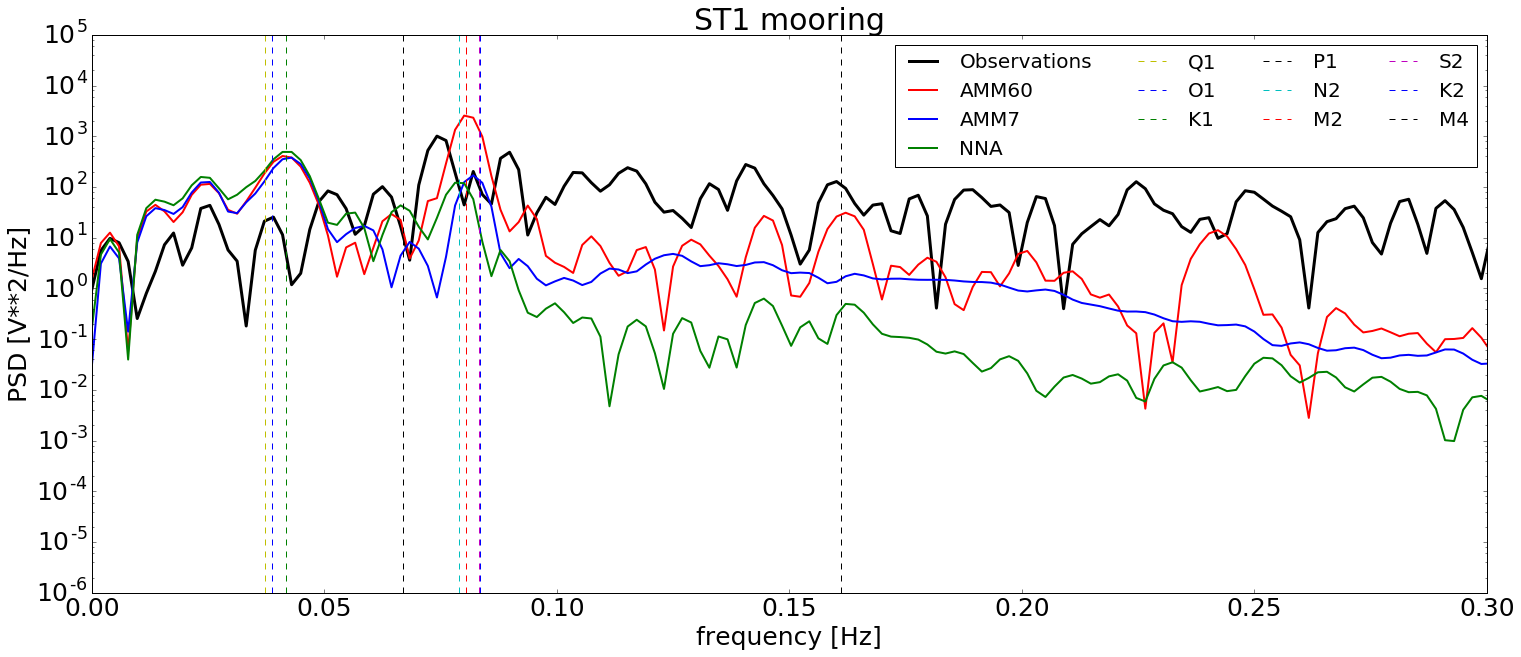

In [27]:
plt.figure(figsize=(25, 10), dpi=250, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

period_hrs = 12.42; lineformat = 'r--'; label='M2'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-2, 1E7], lineformat)
#ax.text(1/(3600*period_hrs), 1E6, label)

plt.semilogy(famm60,fftobsamm60,color='k',label='Observations',linewidth=3)
plt.semilogy(famm60,fftmodamm60,color='r',label='AMM60',linewidth=2)
plt.semilogy(famm7,fftmodamm7,color='b',label='AMM7',linewidth=2)
plt.semilogy(fnna,fftmodnna,color='g',label='NNA',linewidth=2)

#period_hrs = 312.00; lineformat = 'k--'; label='M2-S2'
#plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='M2-S2')

period_hrs = 26.87; lineformat = 'y--'; label='Q1'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='Q1')

period_hrs = 25.82; lineformat = 'b--'; label='O1'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='O1')

period_hrs = 23.93; lineformat = 'g--'; label='K1'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='K1')

period_hrs = 14.96; lineformat = 'k--'; label='P1'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='P1')

period_hrs = 12.66; lineformat = 'c--'; label='N2'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='N2')

period_hrs = 12.42; lineformat = 'r--'; label='M2'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='M2')

period_hrs = 12.00; lineformat = 'm--'; label='S2'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='S2')

period_hrs = 11.967; lineformat = 'b--'; label='N2'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='K2')

period_hrs = 6.21; lineformat = 'k--'; label='M4'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='M4')






plt.xlim([0,0.3])
plt.ylim([1E-6, 1E5])
plt.title(mooring_num+' mooring')
if (mooring_num == 'ST1'):
    plt.legend(fontsize=20, loc='upper right', ncol=4)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

name = 'fft_'+mooring_num+'.png'
plt.savefig(str(name))

plt.show()
